In [17]:
%matplotlib inline
from effective_quadratures.PolyParams import PolynomialParam
from effective_quadratures.PolyParentFile import PolyParent
from effective_quadratures.IndexSets import IndexSet
from effective_quadratures.Utils import column, evalfunction
import effective_quadratures.MatrixRoutines as mat
import effective_quadratures.ComputeStats as stats
from effective_quadratures.EffectiveQuadSubsampling import EffectiveSubsampling
import numpy as np
import matplotlib.pyplot as plt

<h1> The Namesake: Effective Quadrature Subsampling

In this notebook we demonstrate what effective quadrature subsampling is and how it may be used to create a polynomial approximation for a computation model. We begin by defining a simple two-dimensional function
$$f(x_1, x_2) = exp(x_1 + x_2)$$
where $x_1$ and $x_2$ are uniformly distributed over the cube $x_1, x_2 
\in [-1,1]$. This will be our 'expensive' computational model. 

Lets first understand what exactly effective quadrature subsampling is and how it computes the pseudospectral coefficients. Have a look at the figure below. In (a) we have a matrix of multivariate orthonormal polynomials evaluated at a tensor grid of quadrature points (rows) and the underlying polynomial basis forms the columns. This basis can be formed from either a total order or hyperbolic cross basis. The "effectively subsampled quadrature points" are obtained by computing the QR column pivoting factorization of A transpose and only taking the first n columns of A transpose as shown in (b). We then compute the coefficients by solving this as a least squares problem. When approximating computational models with noise, one may need to eliminate a few extra columns to get a good least squares approximant; as in (c) and (d). 

<img src='Matrices.png'>

To clarify the above, let us run though an example problem with the exponential function:

In [3]:
def exponential_function(x):
    return np.exp(x[0] + x[1])

Declare the two inputs and their ranges

In [4]:
no_pts_x1 = 5
no_pts_x2 = 5
min_range = -1.0
max_range = 1.0
x1 = PolynomialParam("Uniform", min_range, max_range, [], [], [], no_pts_x1)
x2 = PolynomialParam("Uniform", min_range, max_range, [], [], [], no_pts_x2)
x1x2 = []
x1x2.append(x1)
x1x2.append(x2)

We will opt for a hyperbolic cross basis, though one can also opt for a total order basis. Bear in mind that we are trying to escape the cost associated with a more conventional tensor grid or sparse grid basis. A hyperbolic cross takes in a *q* parameter. When *q=1* we have a total order basis. Note that the cardinality of the hyperbolic cross sets the maximum number of function evaluations required. 

In [20]:
q = 0.5
hyperbolic_cross = IndexSet("hyperbolic cross", [no_pts_x1, no_pts_x2], q)
maximum_number_of_evals = IndexSet.getCardinality(hyperbolic_cross)
print maximum_number_of_evals

10


Lets plot this index set which has 10 terms:

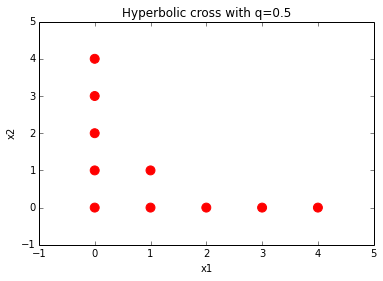

In [21]:
indexset = IndexSet.getIndexSet(hyperbolic_cross)
plt.scatter(column(indexset,0), column(indexset,1), marker='o', s=80, color='red');
plt.xlabel('x1');
plt.ylabel('x2');
plt.title('Hyperbolic cross with q=0.5');

The class Effective_Subsampling has holds all the function calls required for effective quadrature subsampling. We begin by declaring an EffectiveSubsampling object that takes as inputs the uncertain parameters, the index set and a derivative flag. In this notebook as derivatives are not considered the derivative flag is set to 0.

In [22]:
effectiveQuads = EffectiveSubsampling(x1x2, hyperbolic_cross, 0)
A_tall, esquad_pts = EffectiveSubsampling.getAsubsampled(effectiveQuads, maximum_number_of_evals)
b_tall = evalfunction(esquad_pts, exponential_function)

Let's plot where these subsamples lie on our existing [no_pts_x1, no_pts_x2] tensor grid. 

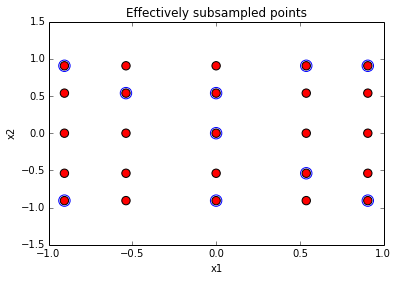

In [36]:
uqProblem = PolyParent(x1x2, "tensor grid")
tensor_pts, wts = PolyParent.getPointsAndWeights(uqProblem)
plt.scatter(tensor_pts[:,0], tensor_pts[:,1], s=70, c='r', marker='o');
plt.scatter(esquad_pts[:,0], esquad_pts[:,1], s=130, facecolor='none', edgecolor='b', marker='o');
plt.xlabel('x1');
plt.ylabel('x2');
plt.title('Effectively subsampled points');

Now before we solve the least squares problem, we have to row normalize our matrices -- to reduce the condition number. A simple utility in "mat" addresses this: 

In [19]:
An, normalizations = mat.rowNormalize(A_tall)
bn = np.dot(normalizations, b_tall)
xn = mat.solveLeastSquares(An, bn)

So how does this coefficient approximation fare with a randomized sampling approach? 